# Vertex AI MLOps Book - Chapter 15 - Recommender System - Movie Recommendations

In [ ]:

# Supporting code for: Vertex AI ML Ops Code - Chapter 15 - Recommender Systems
#Reference: 
#https://keras.io/examples/structured_data/collaborative_filtering_movielens/

 # https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/model_registry/get_started_with_model_registry.ipynb

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at: https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

##### In this notebook we will create a movie recommendation system using Keras. We will use the MovieLens dataset to train our model. 

##### We will use the following steps to create our recommendation system:
* Download the MovieLens dataset
* Train a Collaborative Filtering model to recommend Movies
* Upload the Model to Vertex AI Model Registry
* Deploy the Model to Vertex AI Endpoint for serving


Data Source: https://grouplens.org/datasets/movielens/

## Set up model resources
 Configure the GCP Project

In [1]:
# In this cell we are 
PROJECT_ID = "jsb-alto"  # @param {type:"string"} 

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


### Create a GCS Bucket to store model artifacts

In [2]:
# Set the bucket name
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

# Set the region
REGION = "us-central1" 

# Create the bucket
! gsutil mb -l {REGION} {BUCKET_URI}

Creating gs://your-bucket-name-jsb-alto-unique/...
ServiceException: 409 A Cloud Storage bucket named 'your-bucket-name-jsb-alto-unique' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


### Import Libraries

In [243]:
#Import libraries
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import os
import google.cloud.aiplatform as aip

#Set HW config
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Download and load data

In [4]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
movielens_data_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zip_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_url, extract=False
)

movie_datasets_path = Path(movielens_zip_file).parents[0]
movielens_dir = movie_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zip_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=movie_datasets_path)
        print("Done!")

In [5]:
# Load the Movie Ratings file
ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


### Pre process the data to encode users and movies as integer indices.

In [6]:
# Extract the unique user IDs from the 'userId' column and convert them to a list
user_ids = df["userId"].unique().tolist()


# Create a dictionary that maps each user ID to a unique integer (encoded form)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

# Create a dictionary that maps each unique integer back to its original user ID
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Extract the unique movie IDs from the 'movieId' column and convert them to a list
movie_ids = df["movieId"].unique().tolist()

# Create a dictionary that maps each movie ID to a unique integer (encoded form)
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Create a dictionary that maps each unique integer back to its original movie ID
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

# Map the original user IDs in the 'userId' column to their encoded forms and store in a new column 'user'
df["user"] = df["userId"].map(user2user_encoded)

# Map the original movie IDs in the 'movieId' column to their encoded forms and store in a new column 'movie'
df["movie"] = df["movieId"].map(movie2movie_encoded)

# Store the number of users and movies in variables
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)


df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


### Split data into train and test sets

In [7]:
# Prepare training and validation data
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalize the rating values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split 90% of data for training and 10% for validation
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

## Create the model

We embed both users and movies in to 50-dimensional vectors.
The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [8]:
# Define the size for embeddings
EMBEDDING_SIZE = 50


# Define the RecommendationModel class, which is a subclass of the keras.Model
class RecommendationModel(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        # User embeddings layer: Represents each user as a vector in the embedding space
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Movie embeddings layer: Represents each movie as a vector in the embedding space
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
     # Forward pass: Given user and movie IDs, predict the rating
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


# # Instantiate the Recommender model with the defined number of users, movies, and embedding size 
model = RecommendationModel(num_users, num_movies, EMBEDDING_SIZE)

# Compile the Recommender model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

2023-09-01 16:33:25.948792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-01 16:33:25.948840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: tf-2-12
2023-09-01 16:33:25.948848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: tf-2-12
2023-09-01 16:33:25.948969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-09-01 16:33:25.948996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-09-01 16:33:25.949001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.105.17


### Train the model

In [9]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 7s 4ms/step - loss: 0.6362 - val_loss: 0.6207
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6133 - val_loss: 0.6206
Epoch 3/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6086 - val_loss: 0.6158
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.6072 - val_loss: 0.6125
Epoch 5/5
1418/1418 [==============================] - 6s 5ms/step - loss: 0.6075 - val_loss: 0.6138


In [10]:
# Print the model summary
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  30500     
                                                                 
 embedding_1 (Embedding)     multiple                  610       
                                                                 
 embedding_2 (Embedding)     multiple                  486200    
                                                                 
 embedding_3 (Embedding)     multiple                  9724      
                                                                 
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


### Plot the training and validation loss

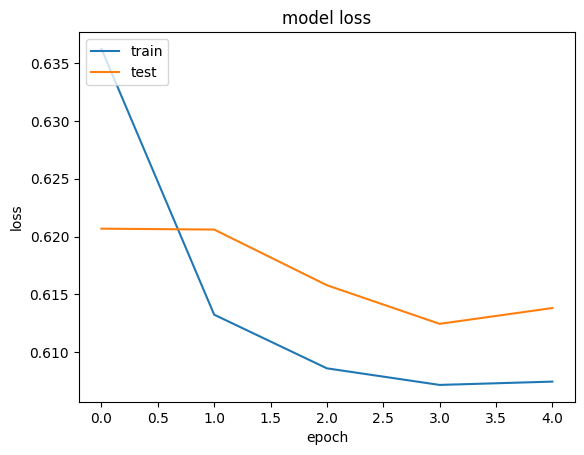

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

## Test model predictions locally 

Create an array with unwatched movies for a random user to use as sample data

In [12]:

#Load the Movie Metadata
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_prediction_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

Predict the ratings for unwatched movies

In [13]:
#Get predicted ratings for the unwatched movies and the selected user
ratings = model.predict(user_prediction_array).flatten()

227/227 [==============================] - 0s 955us/step


In [94]:
# Sort and pick top 10 ratings
movie_indices_top10 = ratings.argsort()[-10:][::-1]

movie_recommendations_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in movie_indices_top10
]

print("----" * 10)
print("Top movies recommendations for user id: {}".format(user_id))
print("----" * 10)
recommended_movies = movie_df[movie_df["movieId"].isin(movie_recommendations_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 41
Movies with high ratings from user
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Clockwork Orange, A (1971) : Crime|Drama|Sci-Fi|Thriller
Zoolander (2001) : Comedy
Along Came Polly (2004) : Comedy|Romance
Kill Bill: Vol. 2 (2004) : Action|Drama|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Volunteers (1985) : Comedy
Emperor's New Clothes, The (2001) : Comedy
Caveman (1981) : Comedy
Juwanna Mann (2002) : Comedy
Top Secret! (1984) : Comedy
Unfaithfully Yours (1948) : Comedy
Oh, God! You Devil (1984) : Comedy
Fish Story (Fisshu sutôrî) (2009) : Comedy
Kevin Smith: Too Fat For 40 (2010) : Comedy
War Dogs (2016) : Comedy


### Save the model to GCS bucket

In [21]:
# Save the model in GCS bucket so that we can import it into Vertex AI Model Registry
MODEL_DIR = BUCKET_URI + "/model/"
model.save(MODEL_DIR)

INFO:tensorflow:Assets written to: gs://your-bucket-name-jsb-alto-unique/model/assets


INFO:tensorflow:Assets written to: gs://your-bucket-name-jsb-alto-unique/model/assets


## Deploy the model to Vertex AI for inference

### Upload the model to Vertex AI Model Registry

In [90]:
## aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

DEPLOY_GPU, DEPLOY_NGPU = (None, None)
TF = "2.12".replace(".", "-")

if DEPLOY_GPU:
    DEPLOY_VERSION = "tf2-gpu.{}".format(TF)
else:
    DEPLOY_VERSION = "tf2-cpu.{}".format(TF)


DEPLOY_IMAGE = "{}-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(
    REGION.split("-")[0], DEPLOY_VERSION
)

In [92]:
model = aip.Model.upload(
    display_name="recommender_model_chp15",
    artifact_uri=MODEL_DIR,
    serving_container_image_uri=DEPLOY_IMAGE,
    is_default_version=True,
    version_aliases=["v1"],
    version_description="This is the first version of the model",
)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/398507275014/locations/us-central1/models/8826147073041629184/operations/8732240739850780672


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/398507275014/locations/us-central1/models/8826147073041629184/operations/8732240739850780672


Model created. Resource name: projects/398507275014/locations/us-central1/models/8826147073041629184@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/398507275014/locations/us-central1/models/8826147073041629184@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/398507275014/locations/us-central1/models/8826147073041629184@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/398507275014/locations/us-central1/models/8826147073041629184@1')


resource name: projects/398507275014/locations/us-central1/models/8826147073041629184


In [93]:
versions = model.versioning_registry.list_versions()
for version in versions:
    print(version)

Getting versions for projects/398507275014/locations/us-central1/models/8826147073041629184


INFO:google.cloud.aiplatform.models:Getting versions for projects/398507275014/locations/us-central1/models/8826147073041629184


VersionInfo(version_id='1', version_create_time=DatetimeWithNanoseconds(2023, 8, 31, 10, 24, 32, 848901, tzinfo=datetime.timezone.utc), version_update_time=DatetimeWithNanoseconds(2023, 8, 31, 10, 24, 37, 224546, tzinfo=datetime.timezone.utc), model_display_name='recommender_model_chp15', model_resource_name='projects/398507275014/locations/us-central1/models/8826147073041629184', version_aliases=['v1', 'default'], version_description='This is the first version of the model')


In [94]:
## List Model versions
models = aip.Model.list(filter="display_name=recommender_model_chp15")
print("Number of models:", len(models))
print("Version ID:", models[0].version_id)

model = models[0]

Number of models: 1
Version ID: 1


## Creating an `Endpoint` resource

- `display_name`: A human readable name for the `Endpoint` resource.
- `project`: Your project ID.
- `location`: Your region.
- `labels`: (optional) User defined metadata for the `Endpoint` in the form of key/value pairs.

This method returns an `Endpoint` object.

In [95]:
endpoint = aip.Endpoint.create(
    display_name="recommender_model_chp15",
    project=PROJECT_ID,
    location=REGION,
    
)
print(endpoint)

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/398507275014/locations/us-central1/endpoints/1721010575376384000/operations/4305202306145583104


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/398507275014/locations/us-central1/endpoints/1721010575376384000/operations/4305202306145583104


Endpoint created. Resource name: projects/398507275014/locations/us-central1/endpoints/1721010575376384000


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/398507275014/locations/us-central1/endpoints/1721010575376384000


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/398507275014/locations/us-central1/endpoints/1721010575376384000')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/398507275014/locations/us-central1/endpoints/1721010575376384000')


resource name: projects/398507275014/locations/us-central1/endpoints/1721010575376384000


### Deploying Models to Endpoints in Vertex AI
Vertex AI allows for the deployment of one or more Model resource instances to a single endpoint. Notably, each deployed Vertex AI Model has its dedicated deployment container for the serving binary.


#### Deploying to an Endpoint
Below, we'll demonstrate how to deploy the default version of a Vertex AI Model resource to a Vertex AI Endpoint. The deployment container image for this model is already specified. However, when deploying, you need to provide additional configurations such as:

* Machine Type: Defines the compute capacity for serving the model.
* GPU Configuration: Optional settings defining type and number of GPUs.
* Scaling: Choices include static, manual, or auto-scaling for VM instances.

For this deployment example, we're keeping it straightforward by specifying:

* model: Refers to the Model resource.
* deployed_model_display_name: A user-friendly name for the deployed model.
* machine_type: Specifies the type of VM for each instance.


Note: Due to the underlying provisioning processes, the deployment might take a few minutes. Please be patient.

In [96]:
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

DEPLOY_COMPUTE = "n1-standard-4"
print("Train machine type", DEPLOY_COMPUTE)

Deployment: us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest None None
Train machine type n1-standard-4


In [97]:
#Deploy the model to the Vertex AI endpoint
response = endpoint.deploy(
    model=model,
    deployed_model_display_name="example_",
    machine_type=DEPLOY_COMPUTE,
)

print(endpoint)

Deploying Model projects/398507275014/locations/us-central1/models/8826147073041629184 to Endpoint : projects/398507275014/locations/us-central1/endpoints/1721010575376384000


INFO:google.cloud.aiplatform.models:Deploying Model projects/398507275014/locations/us-central1/models/8826147073041629184 to Endpoint : projects/398507275014/locations/us-central1/endpoints/1721010575376384000


Deploy Endpoint model backing LRO: projects/398507275014/locations/us-central1/endpoints/1721010575376384000/operations/373559831451140096


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/398507275014/locations/us-central1/endpoints/1721010575376384000/operations/373559831451140096


Endpoint model deployed. Resource name: projects/398507275014/locations/us-central1/endpoints/1721010575376384000


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/398507275014/locations/us-central1/endpoints/1721010575376384000


resource name: projects/398507275014/locations/us-central1/endpoints/1721010575376384000


#### Get information on the deployed model

You can get the deployment settings of the deployed model from the `Endpoint` resource configuration data `gca_resource.deployed_models`. In this example, only one model is deployed -- hence the reference to the subscript `[0]`.

In [105]:
endpoint.gca_resource.deployed_models[0]

id: "3871206718562107392"
model: "projects/398507275014/locations/us-central1/models/8826147073041629184"
display_name: "example_"
create_time {
  seconds: 1693477496
  nanos: 248795000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
model_version_id: "1"

## Run inference on the Vertex AI model Endpoint 

In [78]:
#Define the Inference function

#from typing import Dict, List, Union
#from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def predict_custom_trained_model_sample(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    """
    `instances` can be either single instance of type dict or a list
    of instances.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    # The format of each instance should conform to the deployed model's prediction input schema.
    #instances = instances if isinstance(instances, list) else [instances]
    instances = [
        json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
    ]
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # The predictions are a google.protobuf.Value representation of the model's predictions.
    predictions = response.predictions
    #for prediction in predictions:
    #    print(" prediction:", dict(prediction))
    return(predictions)

# Create sample inference dataset

### Get a user and see the top recommendations.

In [225]:
# Let us get a user and see the top recommendations. Pick Random User
user_id = df.userId.sample(1).iloc[0]
#user_id = 41

#Add filter for the category for which you need recommendations
genre_filter = "Drama"

In [226]:
# Create Test Dataset for a User and the selected Genre
movie_df = pd.read_csv(movielens_dir / "movies.csv")

movies_watched_by_user = df[df.userId == user_id]
#movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values) ]["movieId"]

#Create Dataframe with Movies not watched by the User
movies_not_watched_df = movie_df[
    #(~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)) & (movie_df["genres"] == genre_filter)
    (~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)) & (movie_df["genres"].str.contains(genre_filter))
][["movieId","title","genres"]]


#movies_not_watched_df.reset_index(inplace = True,drop=True)
movies_not_watched = movies_not_watched_df["movieId"]
#movies_not_watched

In [227]:
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
#movies_not_watched

In [229]:
user_encoder = user2user_encoded.get(user_id)
user_prediction_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched) )

In [230]:
#userId
#user_id,user_encoder
#movies_not_watched_df

In [232]:
#Create data instances that would be sent to the API for inference
instances = user_prediction_array.tolist()

In [233]:
# Get predicted ratings for the unwatched movies and the selected user
predictions = predict_custom_trained_model_sample(
    project=endpoint.project,
    endpoint_id=endpoint.name,
    location=endpoint.location,
    instances = instances
)

response
 deployed_model_id: 3871206718562107392


In [234]:
# Create a DataFrame from the predictions list/array
predictions_df = pd.DataFrame(predictions)

# Rename the column in the predictions DataFrame to 'rating'
predictions_df.columns = ['rating']

# Create a DataFrame from the instances list/array
instances_df = pd.DataFrame(instances)

# Rename the columns in the instances DataFrame to 'userId' and 'movieId' respectively
instances_df.columns = ['userId','movieId']

In [235]:
# Merge the instances and predictions DataFrames 
combined_results = instances_df.join(predictions_df)
#combined_results

# Sort the results by the rating column in descending order
combined_results_sorted = combined_results.sort_values('rating',ascending=False)
#combined_results_sorted

# Filter the results to show only the top 20 results
combined_results_sorted_top = combined_results_sorted.head(20)["movieId"].values
#combined_results_sorted_top

In [237]:
#recommended_movie_ids = [
#    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
#]

In [238]:
# Map the encoded Movie IDs to the actual Movie IDs
recommended_movie_ids = [
    movie_encoded2movie.get(x) for x in combined_results_sorted_top
]

In [239]:
#recommended_movie_ids

In [240]:
print("----" * 10)
print("Top 20 recommended movies recommendations for User:",user_id," and Genre",genre_filter)
print("Genre:",genre_filter)
print("----" * 10)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

----------------------------------------
Top 20 recommended movies recommendations for User: 551  and Genre Drama
Genre: Drama
--------------------------------
Stunt Man, The (1980) : Action|Adventure|Comedy|Drama|Romance|Thriller
Affair of the Necklace, The (2001) : Drama
Baran (2001) : Adventure|Drama|Romance
Business of Strangers, The (2001) : Action|Drama|Thriller
No Man's Land (2001) : Drama|War
Blue Angel, The (Blaue Engel, Der) (1930) : Drama
Moscow on the Hudson (1984) : Comedy|Drama
Iris (2001) : Drama
Kandahar (Safar e Ghandehar) (2001) : Drama
Lantana (2001) : Drama|Mystery|Thriller
Brothers (Brødre) (2004) : Drama
Flightplan (2005) : Action|Drama|Thriller
Green Street Hooligans (a.k.a. Hooligans) (2005) : Crime|Drama
History of Violence, A (2005) : Action|Crime|Drama|Thriller
Oliver Twist (2005) : Drama
Greatest Game Ever Played, The (2005) : Drama
Capote (2005) : Crime|Drama
First Snow (2006) : Drama|Thriller
Broken Arrow (1950) : Drama|Romance|Western
TiMER (2009) : Comed